In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:


# Load dataset
dataframe = pd.read_csv("./spam.csv", encoding='latin')
print(dataframe.head())
print(dataframe.info())
print(dataframe.describe())


     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
m

In [8]:

# Drop unnecessary columns
dataframe.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
print(dataframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [10]:
# Rename columns
dataframe.rename(columns={'v1': 'Category', 'v2': 'Message'}, inplace=True)

In [12]:
# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dataframe['Category'] = label_encoder.fit_transform(dataframe['Category'])
print(dataframe.head())
print(dataframe.shape)
print(dataframe.isnull().sum())

   Category                                            Message
0         0  Go until jurong point, crazy.. Available only ...
1         0                      Ok lar... Joking wif u oni...
2         1  Free entry in 2 a wkly comp to win FA Cup fina...
3         0  U dun say so early hor... U c already then say...
4         0  Nah I don't think he goes to usf, he lives aro...
(5572, 2)
Category    0
Message     0
dtype: int64


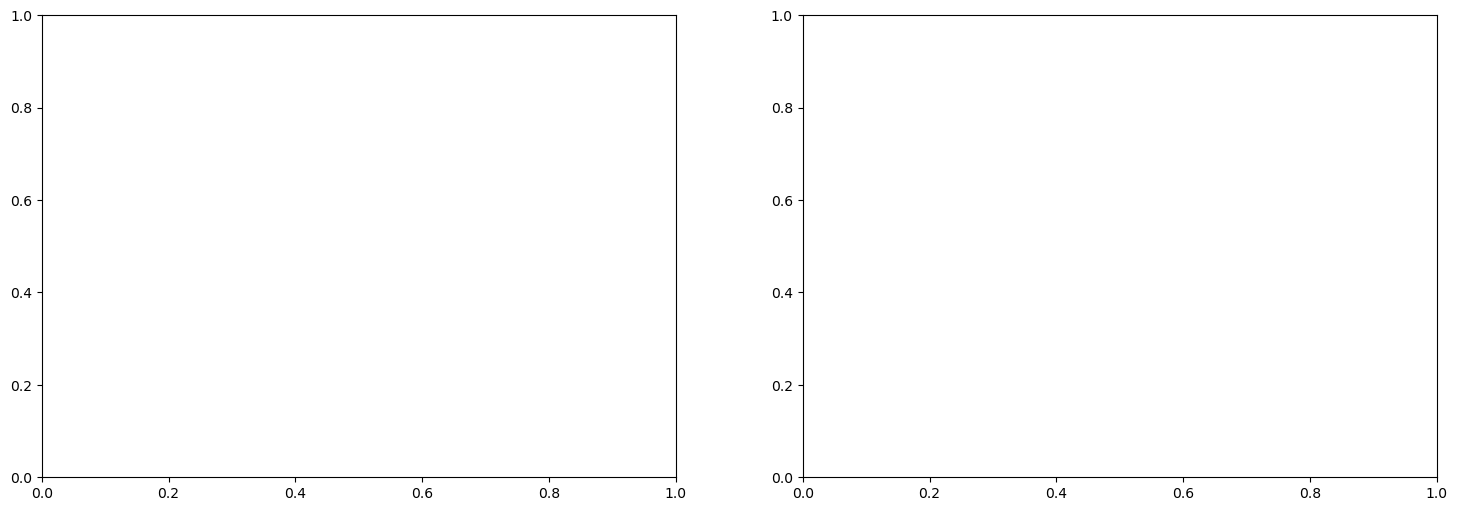

In [14]:
# Visualization
category_counts = dataframe['Category'].value_counts()
custom_colors = ['orange', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

In [16]:
# Pie chart
axes[0].pie(
    category_counts,
    explode=[0.05, 0.1],
    labels=['Ham', 'Spam'],
    autopct='%1.2f%%',
    colors=custom_colors,
    shadow=True
)
axes[0].set_title('Category Distribution (%)')

Text(0.5, 1.0, 'Category Distribution (%)')

In [18]:
# Bar plot
sns.countplot(
    x='Category', 
    data=dataframe, 
    palette=custom_colors, 
    edgecolor='gray', 
    ax=axes[1],
    width=0.5
)
for patch in axes[1].patches:
    axes[1].text(
        patch.get_x() + patch.get_width() / 2, 
        patch.get_height(), 
        int(patch.get_height()), 
        ha='center', 
        fontsize=10
    )
axes[1].set_xticklabels(['Ham', 'Spam'])
axes[1].set_title('Category Count')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [20]:
# Feature extraction
X = dataframe['Message']
Y = dataframe['Category']
tfidf = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
X_tfidf = tfidf.fit_transform(X)
print(X_tfidf.shape)

(5572, 8404)


In [22]:
# Resampling
over_sampler = SMOTE(sampling_strategy=1.0)
under_sampler = RandomUnderSampler(sampling_strategy=0.5)
resampling_pipeline = Pipeline(steps=[('under', under_sampler), ('over', over_sampler)])
X_resampled, Y_resampled = resampling_pipeline.fit_resample(X_tfidf, Y)
print(Counter(Y_resampled))

Counter({0: 1494, 1: 1494})


In [24]:
# Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)

In [26]:
# Model training and evaluation
def train_and_evaluate(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)

    from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
    print(f"ROC AUC Score: {roc_auc_score(Y_test, predictions):.2f}")
    print("Classification Report:\n", classification_report(Y_test, predictions))

    # Confusion Matrix
    cm = confusion_matrix(Y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

XGBoost Model Evaluation
ROC AUC Score: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       470
           1       0.98      0.94      0.96       427

    accuracy                           0.96       897
   macro avg       0.96      0.96      0.96       897
weighted avg       0.96      0.96      0.96       897



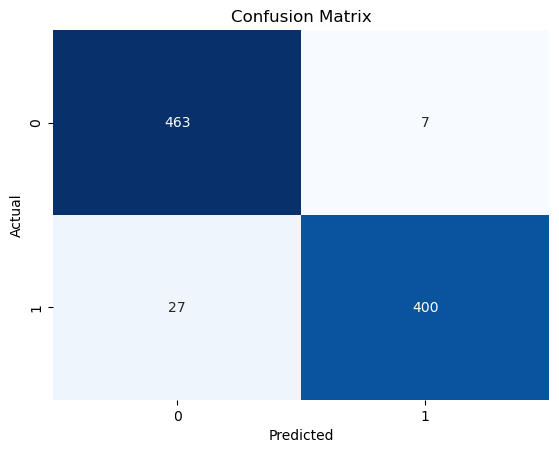

Logistic Regression Model Evaluation
ROC AUC Score: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       470
           1       0.99      0.95      0.97       427

    accuracy                           0.97       897
   macro avg       0.97      0.97      0.97       897
weighted avg       0.97      0.97      0.97       897



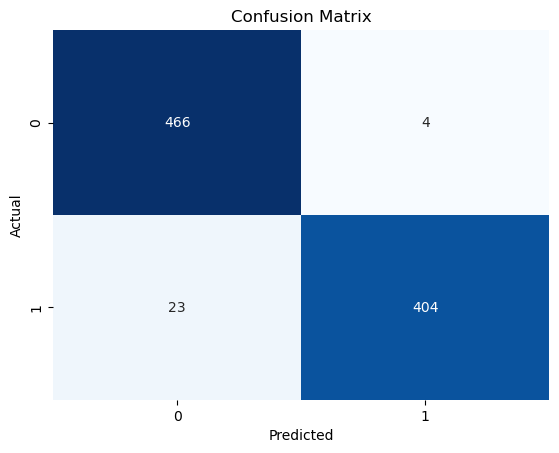

In [28]:
# Classifier models
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.05, max_depth=3, n_estimators=500)

print("XGBoost Model Evaluation")
train_and_evaluate(xgb_model, X_train, Y_train, X_test, Y_test)

from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(C=1.0, penalty='l2')

print("Logistic Regression Model Evaluation")
train_and_evaluate(lr_model, X_train, Y_train, X_test, Y_test)

In [32]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load the tokenizer and model
transformer_tokenizer = AutoTokenizer.from_pretrained("dima806/sms-spam-detection-distilbert")
transformer_model = AutoModelForSequenceClassification.from_pretrained("dima806/sms-spam-detection-distilbert")

# Create the pipeline with both tokenizer and model
sms_pipeline = pipeline("text-classification", model=transformer_model, tokenizer=transformer_tokenizer)

# Sample message
sample_message = "Congratulations! You've won a $1000 Walmart gift card. Call now to claim."

# Run the pipeline on the sample message
print(sms_pipeline(sample_message))


Device set to use cpu


[{'label': 'ham', 'score': 0.9970300197601318}]


In [37]:
!pip install gradio


In [39]:
# Gradio interface
import gradio as gr
def classify_sms(message):
    result = sms_pipeline(message)
    return {"Spam Score": result[0]['score']}

gui = gr.Interface(
    fn=classify_sms,
    inputs=gr.Textbox(label="Enter SMS Message"),
    outputs=gr.Label(label="Spam Score")
)

if __name__ == "__main__":
    gui.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
